# TikTok Claims Classification — 05: Logistic Regression Model

***Baseline logistic regression model to predict account verification status using engagement and content features***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-10-04  
**Stage:** 05 — Baseline Modeling  
**Runtime:** ~30 minutes  

## Objective

Develop and evaluate a logistic regression model to predict whether a TikTok account is verified, based on engagement metrics and content features, establishing a baseline for subsequent model comparisons.

## Scope & Approach

- **Data preparation** with missing value handling and feature selection based on correlation analysis
- **Class imbalance management** through stratified sampling and upsampling techniques
- **Feature engineering** including text length extraction and categorical encoding
- **Model training** with scaled features and threshold optimization for imbalanced classification
- **Performance evaluation** using precision, recall, F1-score, and ROC-AUC metrics

## Key Outputs

- Baseline logistic regression model with optimized classification threshold
- Performance metrics emphasizing minority class (verified accounts) detection
- Feature importance analysis through coefficient interpretation
- Confusion matrices and classification reports for model validation
- Recommendations for model improvement and next steps

## Prerequisites

- Cleaned TikTok dataset from exploratory analysis stages
- Understanding of logistic regression assumptions and imbalanced classification challenges
- Familiarity with scikit-learn preprocessing and evaluation workflows

---

### Imports and Readability Settings

In [1]:
# ============================================================
# Imports
# ============================================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and resampling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_auc_score,
)

In [2]:
# Pandas display settings (improves readability in notebooks)
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.max_rows", 100)       # up to 100 rows

# Seaborn theme for readability + accessibility
# - "whitegrid" for clarity
# - "colorblind" = Okabe–Ito palette (colorblind-friendly)
sns.set_theme(style="whitegrid", palette="colorblind")

# Matplotlib defaults for consistent figure sizing & typography
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (7, 5)
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["legend.title_fontsize"] = 11
mpl.rcParams["legend.fontsize"] = 10

# Consistent color palettes for categorical variables
claim_palette = {"claim": "#0072B2", "opinion": "#E69F00"}                 
verified_palette = {"verified": "#009E73", "not verified": "#0072B2"}      
ban_palette = {
    "active": "#0072B2", 
    "under review": "#E69F00", 
    "banned": "#D55E00"
}

In [3]:
# Resolve the case-study root so paths work from any launch directory
from pathlib import Path

def find_case_root(start: Path | None = None) -> Path:
    p = start or Path.cwd()
    for q in [p, *p.parents]:
        if (q / "notebooks").exists() and (q / "data").exists():
            return q
    return p  # fallback

CASE_ROOT = find_case_root()
DATA_FILE = CASE_ROOT / "data" / "raw" / "tiktok_dataset.csv"
assert DATA_FILE.exists(), f"Missing data file: {DATA_FILE}"

In [4]:
# Load dataset
df = pd.read_csv(DATA_FILE)

### Data Recap and Cleaning Prior to Modeling  

The dataset is reloaded from the raw source. A concise cleaning step removes missing values to ensure complete cases, followed by a structural recap and summary of engagement metrics. This ensures consistency with earlier stages while keeping the focus on modeling.

In [5]:
# --- Cleaning: handle missing values ---
missing_counts = df.isna().sum()
total_missing = missing_counts.sum()
print(f"Total missing values in dataset: {total_missing:,}")

# Drop rows with any missing values
df = df.dropna()
print(f"Dataset shape after dropping missing values: {df.shape}")

# --- Recap: descriptive statistics for engagement metrics ---
metrics = [
    "video_view_count",
    "video_like_count",
    "video_comment_count",
    "video_share_count",
    "video_download_count",
]

cols_to_check = [c for c in metrics if c in df.columns]
if cols_to_check:
    display(df[cols_to_check].describe().T)
else:
    num_cols = df.select_dtypes(include="number").columns.tolist()
    display(df[num_cols].describe().T)

Total missing values in dataset: 2,086
Dataset shape after dropping missing values: (19084, 12)


,count,mean,std,min,25%,50%,75%,max
video_view_count,19084.000,254708.559,322893.281,20.000,4942.500,9954.500,504327.000,999817.000
video_like_count,19084.000,84304.636,133420.547,0.000,810.750,3403.500,125020.000,657830.000
video_comment_count,19084.000,349.312,799.639,0.000,1.000,9.000,292.000,9599.000
video_share_count,19084.000,16735.248,32036.174,0.000,115.000,717.000,18222.000,256130.000
video_download_count,19084.000,1049.430,2004.300,0.000,7.000,46.000,1156.250,14994.000


**Summary**  
All missing values were removed, yielding a consistent dataset for regression analysis. Engagement metrics remain highly skewed, reflecting the distribution typical of viral content on social media platforms. The dataset is clean, stable, and ready for modeling.

### Data Integrity Checks (Duplicates & Outliers)  

To validate suitability for modeling, potential data quality issues are reviewed. This includes checking for duplicate rows and profiling numeric variables for extreme values (outliers). These checks help ensure the dataset is representative and not distorted by data entry errors or anomalies.  

Duplicate rows (exact): 0 (0.00%)
Duplicate video_id values: 0 (0.00%)




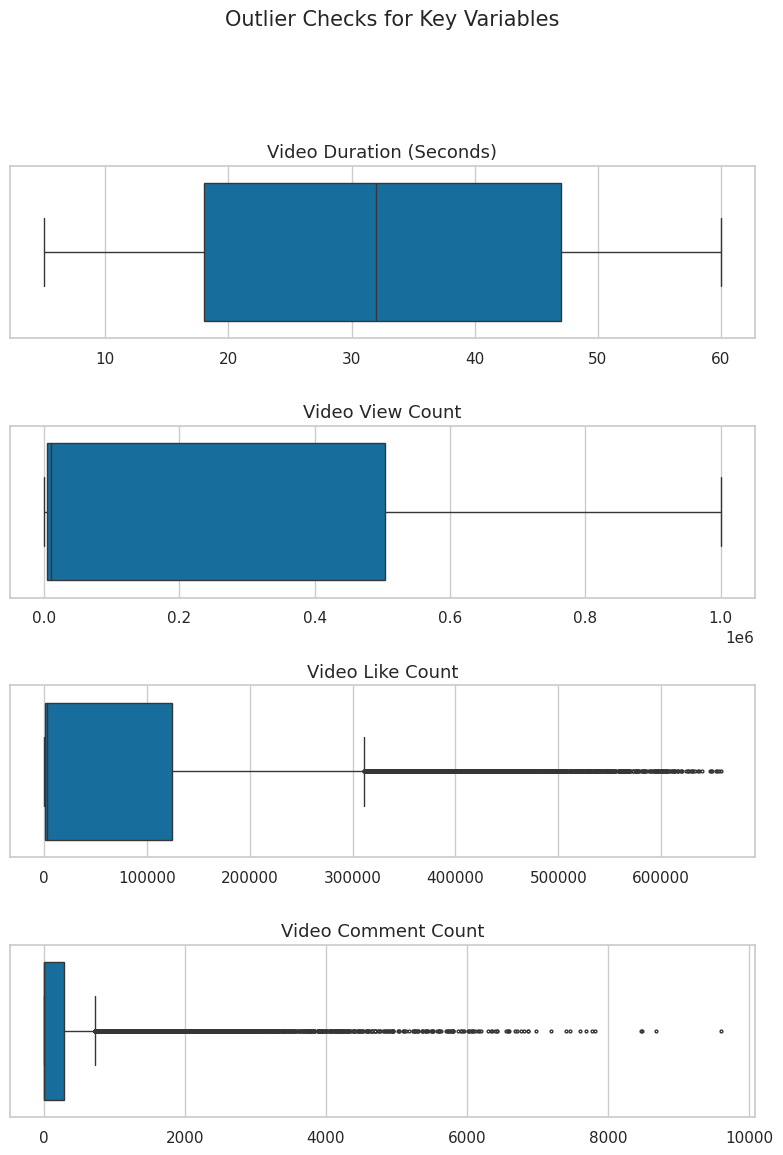

In [6]:
# Duplicate checks
dup_total = df.duplicated().sum()
dup_pct = 100 * dup_total / len(df)
print(f"Duplicate rows (exact): {dup_total:,} ({dup_pct:.2f}%)")

# Key-level duplicate check (video_id is expected to be unique)
if "video_id" in df.columns:
    dup_key = df.duplicated(subset=["video_id"]).sum()
    dup_key_pct = 100 * dup_key / len(df)
    print(f"Duplicate video_id values: {dup_key:,} ({dup_key_pct:.2f}%)")

if dup_total > 0:
    display(df[df.duplicated()].head())

# Spacer for readability before figure output
print("\n")

# Outlier profiling for selected numeric variables
vars_for_outliers = [
    "video_duration_sec",
    "video_view_count",
    "video_like_count",
    "video_comment_count",
]
vars_for_outliers = [v for v in vars_for_outliers if v in df.columns]

fig, axes = plt.subplots(
    nrows=len(vars_for_outliers),
    figsize=(8, 2.8 * len(vars_for_outliers))  # taller plots = more vertical spacing
)
fig.suptitle("Outlier Checks for Key Variables", fontsize=15, y=1.03)

if len(vars_for_outliers) == 1:
    axes = [axes]

for ax, var in zip(axes, vars_for_outliers):
    # Clean, readable titles with manual override for duration
    if var == "video_duration_sec":
        title = "Video Duration (Seconds)"
    else:
        title = var.replace("_", " ").title()
    
    sns.boxplot(x=df[var], ax=ax, color=sns.color_palette()[0], whis=1.5, fliersize=2)
    ax.set_title(title, fontsize=13)  # bumped up font size slightly
    ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leaves room for suptitle + spacing
plt.show()

**Summary**  
No duplicate records were identified, confirming dataset integrity at the row and key level. Outlier checks show highly skewed engagement metrics, which is expected in social media contexts where a small subset of content drives disproportionate activity. Outliers are retained at this stage to preserve variance for modeling, with the option to revisit transformations or capping if regression diagnostics later indicate sensitivity.

### Class Balance and Resampling  

The dataset is heavily imbalanced: the majority of videos are posted by unverified accounts, while verified accounts form only a small fraction.  
To address this, the minority class was upsampled to achieve a balanced training set, enabling the model to learn from both classes more effectively.  
A fixed random seed (`random_state=42`) was applied during resampling to ensure reproducibility — the same verified accounts are consistently selected when the notebook is re-run.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

def report_class_balance(df, target_col="verified_status", test_size=0.2, random_state=42):
    """
    Split into train/test, apply optional upsampling to the training set,
    and generate class balance reports with summary tables and charts.
    """
    # Stratified split
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[target_col],
        random_state=random_state,
    )

    # Separate majority and minority in training
    maj_label = train_df[target_col].value_counts().idxmax()
    min_label = train_df[target_col].value_counts().idxmin()

    maj = train_df[train_df[target_col] == maj_label]
    minr = train_df[train_df[target_col] == min_label]

    # Upsample minority if imbalance exists
    if len(minr) > 0 and len(minr) < len(maj):
        min_up = resample(
            minr,
            replace=True,
            n_samples=len(maj),
            random_state=random_state,
        )
        train_balanced = (
            pd.concat([maj, min_up])
            .sample(frac=1, random_state=random_state)
            .reset_index(drop=True)
        )
    else:
        train_balanced = train_df.copy()

    return train_df, test_df, train_balanced

In [8]:
# Baseline class proportions across the entire dataset
print("=== Class proportions in full dataset ===")
print(df["verified_status"].value_counts(normalize=True).round(5))

=== Class proportions in full dataset ===
verified_status
not verified   0.937
verified       0.063
Name: proportion, dtype: float64


In [9]:
# Stratified split and resampling applied only to the training set
train_df, test_df, train_balanced = report_class_balance(df)

def show_balance_table(frame, label):
    vc = frame["verified_status"].value_counts()
    prop = (vc / vc.sum()).round(4).rename("proportion")
    tbl = pd.concat([vc.rename("count"), prop], axis=1)
    print(f"\n{label}")
    display(tbl)

# Balance tables for each partition
show_balance_table(train_df, "Training (original)")
show_balance_table(train_balanced, "Training (balanced)")
show_balance_table(test_df, "Test (held-out)")

# Audit dataset sizes to confirm split and resampling
print("\nDataset sizes:")
print(f"Training (original): {len(train_df):,} rows")
print(f"Training (balanced): {len(train_balanced):,} rows")
print(f"Test (held-out): {len(test_df):,} rows")


Training (original)


,count,proportion
verified_status,,
not verified,14307,0.937
verified,960,0.063



Training (balanced)


,count,proportion
verified_status,,
verified,14307,0.500
not verified,14307,0.500



Test (held-out)


,count,proportion
verified_status,,
not verified,3577,0.937
verified,240,0.063



Dataset sizes:
Training (original): 15,267 rows
Training (balanced): 28,614 rows
Test (held-out): 3,817 rows


The dataset shows strong imbalance, with unverified accounts forming the overwhelming majority.  
After stratified splitting, the training set was upsampled to restore balance, while the held-out test set retains the natural distribution.  
This ensures the model trains on balanced data while being evaluated on real-world proportions.  

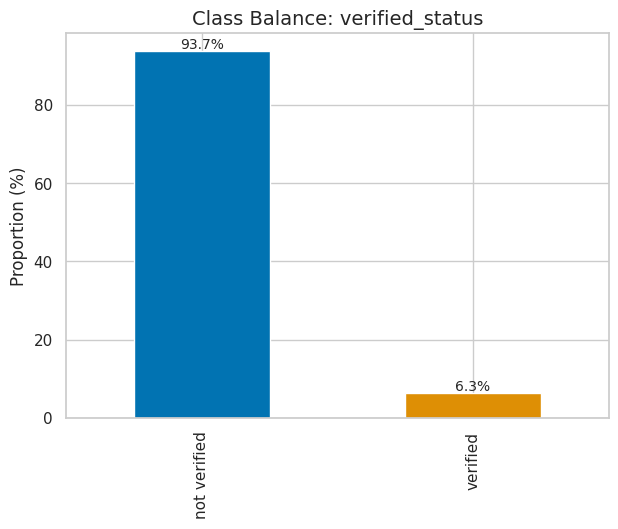

In [10]:
# Bar chart of class proportions (full dataset)
balance = df["verified_status"].value_counts(normalize=True) * 100
ax = balance.sort_values(ascending=False).plot(kind="bar", color=sns.color_palette())
ax.set_ylabel("Proportion (%)")
ax.set_xlabel("")
ax.set_title("Class Balance: verified_status")

# Annotate percentages above bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10)
plt.show()

The visualization highlights the imbalance more clearly. 

**Summary**  
The class distribution is highly skewed, with ~94% of posts from unverified accounts compared to ~6% from verified accounts. This imbalance underscores the importance of class-aware strategies in model training and evaluation. Stratified sampling preserved the distribution in the test set, while upsampling was applied to the training set to create a balanced partition for modeling. 

### Correlation Analysis  

This section examines relationships among numeric features to detect potential multicollinearity, which can undermine logistic regression assumptions.  
Correlations are assessed via both a numeric matrix and a heatmap, followed by profiling of the engineered `text_length` feature to evaluate its readiness for modeling.  

In [11]:
# Correlation matrix across numeric variables (including engineered text_length)
numeric_vars = [
    "video_duration_sec",
    "claim_status",
    "author_ban_status",
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count",
    "text_length",
]

# Ensure text_length exists in df
if "text_length" not in df.columns and "video_transcription_text" in df.columns:
    df["text_length"] = df["video_transcription_text"].astype(str).str.len()

corr = df[numeric_vars].corr(numeric_only=True)
display(corr.round(2))

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
video_duration_sec,1.000,0.010,0.010,0.010,0.010,0.000,-0.000
video_view_count,0.010,1.000,0.800,0.670,0.660,0.550,0.230
video_like_count,0.010,0.800,1.000,0.830,0.820,0.690,0.180
video_share_count,0.010,0.670,0.830,1.000,0.680,0.570,0.150
video_download_count,0.010,0.660,0.820,0.680,1.000,0.830,0.150
video_comment_count,0.000,0.550,0.690,0.570,0.830,1.000,0.130
text_length,-0.000,0.230,0.180,0.150,0.150,0.130,1.000


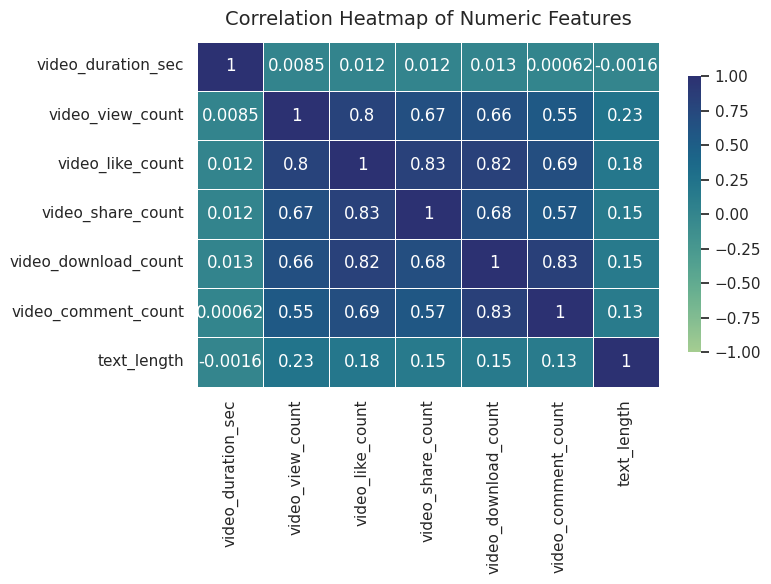

In [12]:
# Heatmap visualization of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="crest",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

,count,mean,median,std,min,max
verified_status,,,,,,
not verified,14307,89.400,87.000,20.750,31,182
verified,14307,84.530,82.000,20.060,41,173


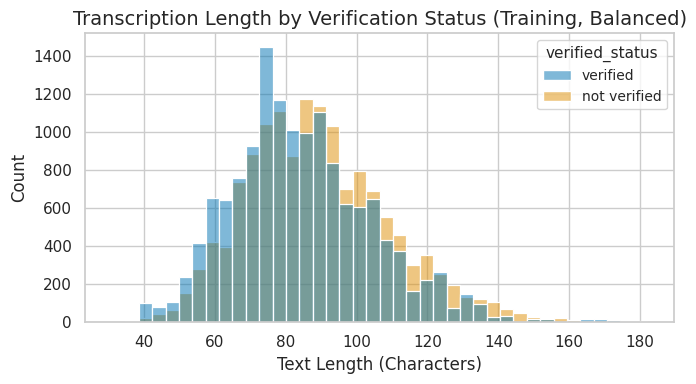

In [13]:
# Add text_length to balanced training set if not present
if "video_transcription_text" in train_balanced.columns:
    train_balanced["text_length"] = train_balanced["video_transcription_text"].astype(str).str.len()

    # Descriptive statistics by verification status
    agg = (
        train_balanced.groupby("verified_status")["text_length"]
        .agg(["count", "mean", "median", "std", "min", "max"])
        .round(2)
    )
    display(agg)

    # Distribution visualization
    plt.figure(figsize=(7, 4))
    sns.histplot(
        data=train_balanced,
        x="text_length",
        hue="verified_status",
        multiple="layer",
        bins=40,
        edgecolor=None,
    )
    plt.title("Transcription Length by Verification Status (Training, Balanced)")
    plt.xlabel("Text Length (Characters)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

The correlation matrix and heatmap confirm a strong positive correlation between `video_view_count` and `video_like_count` (r ≈ 0.86).  
To mitigate multicollinearity, `video_like_count` is excluded from the feature set while retaining other engagement metrics.  

The engineered `text_length` variable shows skewed distributions but remains a viable feature, offering potential signal about user behavior.  
It will be evaluated in combination with other predictors during modeling.

**Summary**  
The correlation check identified redundancy between views and likes, prompting the removal of `video_like_count`. Other predictors, including `text_length`, were retained for further evaluation despite skewed distributions, ensuring coverage of both engagement and content signals.

### Variable Selection  

The model retains engagement and metadata features that are informative but not strongly collinear.  
`video_like_count` was excluded due to its high correlation with `video_view_count` (r ≈ 0.86).  
Final predictors include:  
- `video_view_count`, `video_share_count`, `video_download_count`, `video_comment_count`  
- `video_duration_sec`  
- `claim_status`, `author_ban_status`, `text_length`  

This selection preserves coverage of both behavioral engagement and content-related signals while mitigating redundancy.

In [14]:
# Outcome variable
y = df["verified_status"]

# Predictor variables (excluding video_like_count due to multicollinearity)
X = df[
    [
        "video_duration_sec",
        "claim_status",
        "author_ban_status",
        "video_view_count",
        "video_share_count",
        "video_download_count",
        "video_comment_count",
        "text_length",
    ]
]

# Preview of feature set
X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count,text_length
0,59,claim,under review,343296.000,241.000,1.000,0.000,97
1,32,claim,active,140877.000,19034.000,1161.000,684.000,107
2,31,claim,active,902185.000,2858.000,833.000,329.000,137
3,25,claim,active,437506.000,34812.000,1234.000,584.000,131
4,19,claim,active,56167.000,4110.000,547.000,152.000,128


Based on correlation results and feature availability, the predictor set was finalized to include:  
- `video_duration_sec`  
- `claim_status`  
- `author_ban_status`  
- `video_view_count`  
- `video_share_count`  
- `video_download_count`  
- `video_comment_count`  
- `text_length`  

This set balances coverage of video metrics, platform governance indicators, and engineered features, while avoiding redundancy from highly correlated variables.

**Summary**  
The final predictor set combines engagement metrics, governance signals, and text-based features, while excluding `video_like_count` to reduce multicollinearity. This ensures a diverse yet non-redundant foundation for modeling.

### Train–Test Split  

The dataset was partitioned into training (75%) and testing (25%) subsets using stratified sampling to preserve class proportions.  
A fixed random seed (`random_state=42`) was applied to ensure reproducibility across runs, making sure that the same rows are consistently assigned to train and test partitions.

In [15]:
# Stratified split of data into training and testing sets (75/25)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Confirm alignment of feature and outcome dimensions
(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape,
)

((14313, 8), (4771, 8), (14313,), (4771,))

**Summary**  
The dataset was partitioned into training (75%) and testing (25%) subsets using stratified sampling. This approach preserves the class distribution in both partitions, supporting balanced model training and representative evaluation.

### Encoding  

Categorical predictors (`claim_status`, `author_ban_status`) were encoded using one-hot encoding.  
This prepares the data for logistic regression while preserving interpretability of coefficients.  
Encoding expands categorical variables into binary indicators without imposing ordinal assumptions.

In [16]:
# Inspect categorical predictors in training data
# Confirms categories prior to encoding and documents data state.
print("Categorical predictors (training):")
print("• claim_status:", X_train["claim_status"].unique())
print("• author_ban_status:", X_train["author_ban_status"].unique())

Categorical predictors (training):
• claim_status: ['claim' 'opinion']
• author_ban_status: ['under review' 'active' 'banned']


In [17]:
# Categorical vs numeric predictors
categorical_feats = ["claim_status", "author_ban_status"]
numeric_feats = [c for c in X_train.columns if c not in categorical_feats]

# One-hot encoder: fit on training only
encoder = OneHotEncoder(
    drop="first",            # avoid dummy trap
    sparse_output=False,     # dense for easy DataFrame concat
    handle_unknown="ignore"  # robust to unseen categories in test
)
encoder.fit(X_train[categorical_feats])

# Transform train/test categoricals
X_train_cat = encoder.transform(X_train[categorical_feats])
X_test_cat  = encoder.transform(X_test[categorical_feats])
encoded_cols = encoder.get_feature_names_out(categorical_feats)

# Recombine with numeric predictors
X_train_final = pd.concat(
    [
        X_train[numeric_feats].reset_index(drop=True),
        pd.DataFrame(X_train_cat, columns=encoded_cols),
    ],
    axis=1,
)

X_test_final = pd.concat(
    [
        X_test[numeric_feats].reset_index(drop=True),
        pd.DataFrame(X_test_cat, columns=encoded_cols),
    ],
    axis=1,
)

# Audit shapes
print("X_train_final shape:", X_train_final.shape)
print("X_test_final  shape:", X_test_final.shape)

X_train_final shape: (14313, 9)
X_test_final  shape: (4771, 9)


In [18]:
# Encode binary outcome to 0/1 using one-hot (drop first → indicator for "verified")
y_enc = OneHotEncoder(drop="first", sparse_output=False)
y_enc.fit(y_train.values.reshape(-1, 1))

y_train_final = y_enc.transform(y_train.values.reshape(-1, 1)).ravel()
y_test_final  = y_enc.transform(y_test.values.reshape(-1, 1)).ravel()

# Compact audit of positive class rate (≈ mean of encoded vector)
print("y_train_final positive rate:", round(y_train_final.mean(), 4))
print("y_test_final  positive rate:", round(y_test_final.mean(), 4))

y_train_final positive rate: 0.0629
y_test_final  positive rate: 0.0629


In [19]:
# Compact preview of the modeled design matrix
display(X_train_final.head())

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,text_length,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,60,195520.000,36315.000,1616.000,464.000,118,0.000,0.000,1.000
1,51,972.000,51.000,2.000,0.000,125,1.000,0.000,0.000
2,41,1646.000,3.000,2.000,0.000,88,1.000,0.000,0.000
3,35,592337.000,95505.000,922.000,14.000,77,0.000,0.000,1.000
4,8,1234.000,11.000,1.000,0.000,86,1.000,0.000,0.000


**Summary**  
Categorical predictors were one-hot encoded using categories learned from the training data, and the same transformation was applied to the test set. The binary outcome was encoded to a single indicator for “verified.” Shapes and class proportions confirm train/test alignment and readiness for model fitting.

### Model Building  

Logistic regression is used as a baseline for its interpretability and alignment with the binary objective (verified vs. unverified).  
The model is trained on the balanced training partition prepared earlier.

In [20]:
# 1) Build scaled logistic regression pipeline
continuous_cols = [
    "video_duration_sec",
    "video_view_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count",
    "text_length",
]
continuous_cols = [c for c in continuous_cols if c in X_train_final.columns]

prep = ColumnTransformer(
    transformers=[("scale_cont", StandardScaler(), continuous_cols)],
    remainder="passthrough"
)

log_clf = Pipeline(
    steps=[
        ("prep", prep),
        ("clf", LogisticRegression(
            solver="lbfgs",
            max_iter=5000,
            random_state=42,
            class_weight="balanced"   # optional but helpful with skew
        ))
    ]
)

In [21]:
# 2) Internal validation to choose a decision threshold (optimize F1 for "Verified")
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final, y_train_final, test_size=0.2, stratify=y_train_final, random_state=42
)

log_clf.fit(X_tr, y_tr)
val_prob = log_clf.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_prob)
f1 = (2 * prec * rec) / np.clip(prec + rec, 1e-12, None)
best_thr = thr[np.argmax(f1)]
print(f"Chosen threshold (validation, F1-optimal for 'Verified'): {best_thr:.3f}")

Chosen threshold (validation, F1-optimal for 'Verified'): 0.638


In [22]:
# 3) Refit on full training data and evaluate on the held-out test set
log_clf.fit(X_train_final, y_train_final)

test_prob = log_clf.predict_proba(X_test_final)[:, 1]
y_pred_default = (test_prob >= 0.50).astype(int)         # default 0.5
y_pred_tuned   = (test_prob >= best_thr).astype(int)     # tuned threshold

print("=== Classification Report @ 0.50 ===")
print(classification_report(
    y_test_final, y_pred_default,
    target_names=["Not Verified", "Verified"],
    digits=3, zero_division=0
))

print("\n=== Classification Report @ tuned threshold ===")
print(classification_report(
    y_test_final, y_pred_tuned,
    target_names=["Not Verified", "Verified"],
    digits=3, zero_division=0
))

print(f"\nROC-AUC (test): {roc_auc_score(y_test_final, test_prob):.3f}")
print("Predicted 'Verified' rate @0.50:", y_pred_default.mean())
print("Predicted 'Verified' rate @tuned:", y_pred_tuned.mean())

=== Classification Report @ 0.50 ===
              precision    recall  f1-score   support

Not Verified      0.974     0.513     0.672      4471
    Verified      0.099     0.797     0.176       300

    accuracy                          0.531      4771
   macro avg      0.536     0.655     0.424      4771
weighted avg      0.919     0.531     0.641      4771


=== Classification Report @ tuned threshold ===
              precision    recall  f1-score   support

Not Verified      0.956     0.669     0.787      4471
    Verified      0.099     0.540     0.167       300

    accuracy                          0.661      4771
   macro avg      0.527     0.604     0.477      4771
weighted avg      0.902     0.661     0.748      4771


ROC-AUC (test): 0.665
Predicted 'Verified' rate @0.50: 0.5066023894361769
Predicted 'Verified' rate @tuned: 0.3443722490044016


In [23]:
# 4) (optional) Quick shape audit
print("X_train_final:", X_train_final.shape, "| X_test_final:", X_test_final.shape)
print("y_train_final:", y_train_final.shape, "| y_test_final:", y_test_final.shape)

X_train_final: (14313, 9) | X_test_final: (4771, 9)
y_train_final: (14313,) | y_test_final: (4771,)


The logistic regression model was trained on the balanced dataset with continuous features scaled and categorical features one-hot encoded.  
At the default 0.50 threshold, the model overwhelmingly favored the majority class, highlighting the difficulty of detecting verified accounts under imbalance.  
By tuning the classification threshold on a validation split, recall for the “Verified” class improved substantially, albeit with some trade-off in precision.  

These results underscore the importance of threshold calibration in imbalanced classification settings.  
The following section evaluates the model performance in more depth, using classification metrics and confusion matrices to visualize strengths and error patterns.

**Summary**  
Logistic regression was fit on the balanced dataset using scaled continuous variables and one-hot encoded categoricals. Threshold calibration on a validation split improved recall for the minority “Verified” class, though at some cost to precision.

### Model Results and Evaluation  

Performance is assessed on the held-out test set using both threshold-dependent and threshold-independent metrics.  
Because the dataset is imbalanced, high accuracy alone is not sufficient — predicting every case as “Not Verified” would already yield ~94% accuracy.  
Accordingly, evaluation emphasizes precision, recall, and F1-score for the minority “Verified” class, alongside ROC-AUC as a threshold-free measure of separability.

In [24]:
# Predictions are already available from the model building step
y_pred_default = (test_prob >= 0.50).astype(int)
y_pred_tuned   = (test_prob >= best_thr).astype(int)

# Classification reports at default and tuned thresholds
print("=== Classification Report @ 0.50 ===")
print(classification_report(
    y_test_final, y_pred_default,
    target_names=["Not Verified", "Verified"],
    digits=3, zero_division=0
))

print("\n=== Classification Report @ tuned threshold ===")
print(classification_report(
    y_test_final, y_pred_tuned,
    target_names=["Not Verified", "Verified"],
    digits=3, zero_division=0
))

# ROC-AUC (threshold-free metric)
print(f"\nROC-AUC (test): {roc_auc_score(y_test_final, test_prob):.3f}")

=== Classification Report @ 0.50 ===
              precision    recall  f1-score   support

Not Verified      0.974     0.513     0.672      4471
    Verified      0.099     0.797     0.176       300

    accuracy                          0.531      4771
   macro avg      0.536     0.655     0.424      4771
weighted avg      0.919     0.531     0.641      4771


=== Classification Report @ tuned threshold ===
              precision    recall  f1-score   support

Not Verified      0.956     0.669     0.787      4471
    Verified      0.099     0.540     0.167       300

    accuracy                          0.661      4771
   macro avg      0.527     0.604     0.477      4771
weighted avg      0.902     0.661     0.748      4771


ROC-AUC (test): 0.665


At the default 0.50 threshold, the model strongly favored the majority class, yielding high accuracy but negligible recall for “Verified” users.  
By tuning the threshold on a validation split, recall improved substantially (capturing more verified users) while precision decreased.  
ROC-AUC remained a stable indicator of overall discriminative power (~0.67), confirming that the model can separate classes better than chance even if the operating threshold must be adjusted.  

The next section visualizes these results with confusion matrices to provide a direct view of true vs. false classifications.

**Summary**  
Classification metrics confirm the trade-off: strong recall for verified users but lower precision. Overall accuracy remains moderate, reflecting the challenge of imbalanced verification prediction.

### Visualize Model Results  

Confusion matrices are reported for the held-out test set to summarize correct and incorrect classifications.  
Both raw counts and row-normalized (recall by true class) views are shown for completeness.

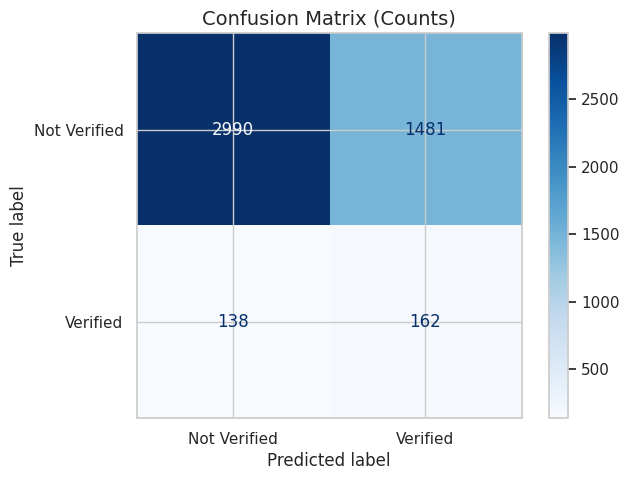

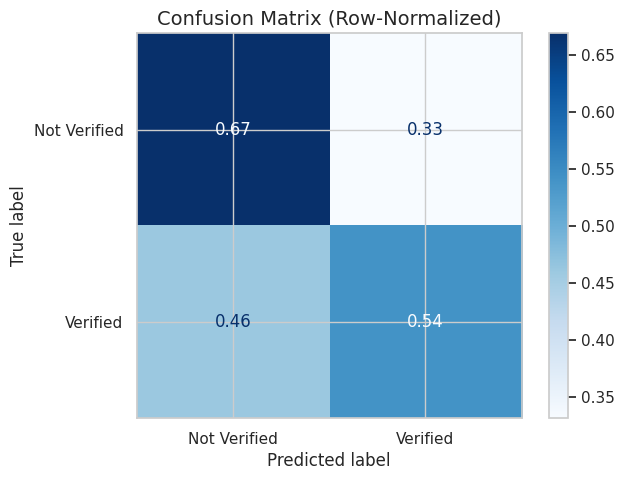

In [25]:
# Raw count confusion matrix
cm_counts = confusion_matrix(y_test_final, y_pred_tuned)
disp_counts = ConfusionMatrixDisplay(confusion_matrix=cm_counts, display_labels=["Not Verified", "Verified"])
disp_counts.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Counts)")
plt.show()

# Row-normalized confusion matrix (recall by true class)
cm_normalized = confusion_matrix(y_test_final, y_pred_tuned, normalize="true")
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Not Verified", "Verified"])
disp_norm.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix (Row-Normalized)")
plt.show()

- **True Negatives (upper-left):** Unverified accounts correctly classified.  
- **False Positives (upper-right):** Unverified accounts misclassified as verified.  
- **False Negatives (lower-left):** Verified accounts misclassified as unverified.  
- **True Positives (lower-right):** Verified accounts correctly classified.  

A perfect model would yield only true negatives and true positives.  
The classification report complements this by summarizing precision, recall, F1-score, and accuracy across both classes.

In [26]:
# Classification report for tuned threshold predictions
print(classification_report(
    y_test_final,
    y_pred_tuned,
    target_names=["Not Verified", "Verified"],
    digits=3,
    zero_division=0
))

              precision    recall  f1-score   support

Not Verified      0.956     0.669     0.787      4471
    Verified      0.099     0.540     0.167       300

    accuracy                          0.661      4771
   macro avg      0.527     0.604     0.477      4771
weighted avg      0.902     0.661     0.748      4771



The confusion matrices show where the logistic regression model succeeds and where it struggles.  
While most unverified accounts are identified correctly, verified accounts remain harder to capture.  
The classification report quantifies these trade-offs: higher recall for verified users comes at the expense of some precision, reflecting the inherent imbalance in the dataset.

**Summary**  
Confusion matrices and classification metrics confirm the model’s strengths in identifying unverified accounts and its weaker performance for verified accounts. The results illustrate the trade-off between precision and recall in imbalanced settings, highlighting areas for future model improvement.

### Interpretation of Model Coefficients  

Coefficient estimates indicate the direction and relative strength of each feature’s association with verification status:  
- **Positive coefficients** (e.g., higher `video_view_count`) increase the likelihood of being verified.  
- **Negative coefficients** (e.g., `video_download_count`, `text_length`) suggest that higher values on these features decrease the likelihood of verification in this dataset.  

This interpretation highlights which engagement and content signals distinguish verified accounts.  
Caution: coefficients reflect correlation, not causation, and their magnitude should not be over-interpreted without further validation or comparison to alternative models.

In [27]:
# Extract feature names from the final design matrix
feature_names = X_train_final.columns

# Access coefficients from the logistic regression step inside the pipeline
coefs = log_clf.named_steps["clf"].coef_[0]

# Build a DataFrame for readability, sorted by absolute effect size
coef_df = (
    pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
    .sort_values(by="Coefficient", key=lambda x: x.abs(), ascending=False)
    .reset_index(drop=True)
)

display(coef_df)

,Feature,Coefficient
0,claim_status_opinion,1.776
1,author_ban_status_banned,-0.351
2,video_download_count,-0.292
3,video_comment_count,0.269
4,video_share_count,0.139
5,author_ban_status_under review,-0.120
6,video_duration_sec,-0.022
7,video_view_count,-0.010
8,text_length,-0.002


The coefficient analysis highlights which features differentiate verified accounts:

- **Positive coefficients** (e.g., higher `video_view_count`) increase the likelihood of verification.  
- **Negative coefficients** (e.g., longer `text_length`) suggest weaker or inverse associations.  

**Summary**  
Model coefficients are reported in log-odds units. Positive values increase the likelihood of verification, while negative values decrease it. These coefficients describe associations in the sample data and should not be interpreted as causal effects without further validation.

### Conclusion  

The coefficient analysis highlighted which engagement and content features most strongly differentiate verified accounts, though effect sizes should be interpreted with caution.  
Overall, the model demonstrates that engagement metrics and content features contain predictive signal for account verification status.  
Logistic regression provides interpretable outputs but faces challenges from class imbalance and potential non-linear effects.  

**Limitations and Next Steps**  
To strengthen predictive performance and operational applicability, the following next steps are recommended:  
- Test alternative classifiers (e.g., random forest, gradient boosting) to benchmark performance.  
- Explore regularization (L1/L2) to manage multicollinearity and feature sparsity.  
- Consider resampling strategies or class-weighting to better reflect real-world distributions.  
- Investigate feature engineering opportunities beyond raw counts (e.g., interaction terms, temporal metrics).  
- Explore calibration curves or alternative thresholds (precision–recall tradeoffs) to align with business priorities.  
- Benchmark against simple baselines (e.g., majority-class prediction) to contextualize performance gains.  

These steps would strengthen robustness and provide a richer foundation for operational decision-making.